# Data preparation / Model

The purpose of this notebook is to prepare the image data aswell as define and train the model.

## Configuration

This unit imports necessary libraries and defines settings for the model. It also validates the dataset.

In [2]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, BatchNormalization, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Vars

BATCH_SIZE = 4
EPOCHS = 10
MODEL_NAME = 'model'
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']
ROOT_DIR = os.path.dirname(os.getcwd())
DATASET_DIR = os.path.join(ROOT_DIR, 'dataset')
DIRS = [os.path.join(ROOT_DIR, DATASET_DIR, dir) for dir in os.listdir(DATASET_DIR)]

In [4]:
# Make sure all images are jpg or png

invalid_images = 0

for dir in DIRS:
    for img in os.listdir(dir):
        if not img.endswith('.jpg') or img.endswith('.png'):
            invalid_images += 1

print(f'Invalid images: {invalid_images}')

Invalid images: 0


## Read data

This unit reads in the dataset created by the DataCollection notebook. It also shuffles the dataset and plots a sample.

In [5]:
# Read images

male_pics = []
female_pics = []

for count, dir in enumerate(DIRS):
    
    for img_file in os.listdir(dir):
        img = cv2.imread(os.path.join(dir, img_file))  # Read image as NumPy array
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (200, 200))  # Resize image to 200x200
        img = img / 255  # Normalize image
        male_pics.append(img) if count == 0 else female_pics.append(img)  # Append image to appropriate list

In [6]:
# Create labels

male_genders = [1] * len(male_pics)
female_genders = [0] * len(female_pics)

In [7]:
# Create dataframe
data = {
    'image' : male_pics + female_pics,
    'gender' : male_genders + female_genders
}

df = pd.DataFrame(data=data)
df.head()

,image,gender
0,"[[[0.996078431372549, 1.0, 0.9803921568627451]...",1
1,"[[[0.7843137254901961, 0.6941176470588235, 0.5...",1
2,"[[[0.3176470588235294, 0.15294117647058825, 0....",1
3,"[[[0.058823529411764705, 0.06666666666666667, ...",1
4,"[[[0.9529411764705882, 1.0, 1.0], [0.952941176...",1


In [8]:
# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

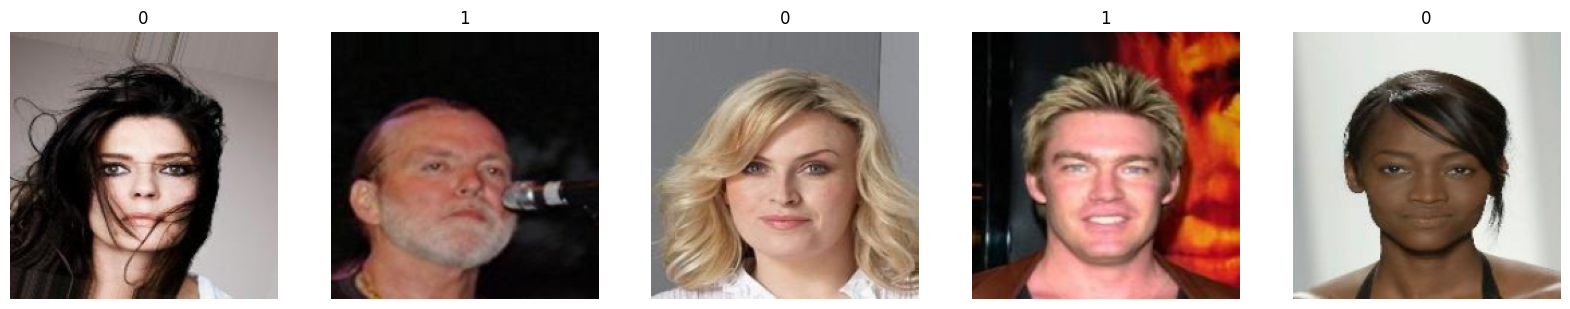

In [21]:
# Plot 5 images
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    ax[i].imshow(df['image'][i])
    ax[i].axis('off')
    ax[i].set_title(df['gender'][i])
plt.show()

## Prepare data

__This unit prepares the data using the following steps:__

    - Split data into train, test and validation
    - Defines X and y variables from dataset
    - One-hot encodes the y variables
    - Creates tensorflow datasets
    - Batches the tensorflow datasets

In [9]:
# Split dataset into train, test, val
X = df['image'].values
y = df['gender']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Flatten and reshape arrays for tensorflow data api

# Flatten arrays
X_train = np.array([image.flatten() for image in X_train])
X_test = np.array([image.flatten() for image in X_test])
X_val = np.array([image.flatten() for image in X_val])

# Reshape arrays
X_train = X_train.reshape(-1, 200, 200, 3)
X_test = X_test.reshape(-1, 200, 200, 3)
X_val = X_val.reshape(-1, 200, 200, 3)

In [11]:
# One hot encode labels
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y=y_train, num_classes=2)
y_test = to_categorical(y=y_test, num_classes=2)
y_val = to_categorical(y=y_val, num_classes=2)

In [12]:
# Create tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

2023-10-09 15:04:02.941736: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2016000000 exceeds 10% of free system memory.
2023-10-09 15:04:05.952008: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 432000000 exceeds 10% of free system memory.
2023-10-09 15:04:07.068707: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 432000000 exceeds 10% of free system memory.


In [20]:
# Define a function to serialize the data
def serialize_example(data, label):
    # Extract the class from the one-hot encoded label
    label_scalar = int(tf.argmax(label).numpy())

    feature = {
        'data': tf.train.Feature(float_list=tf.train.FloatList(value=data.numpy().flatten())),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label_scalar])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Serialize all test examples into a list
serialized_examples = []

for data, label in test_dataset:
    example_proto = serialize_example(data, label)
    serialized_examples.append(example_proto)

# Define the TFRecord filename
tfrecord_filename = 'test_data.tfrecord'

# Create a TFRecord writer
writer = tf.data.experimental.TFRecordWriter(tfrecord_filename)

# Write all serialized examples to the TFRecord file
for example_proto in serialized_examples:
    writer.write(example_proto)

# Close the TFRecord writer
writer.close()


TypeError: Invalid `dataset.` Expected a `tf.data.Dataset` object but got <class 'bytes'>.

In [26]:
# Batch datasets

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

## Define model

This unit defines the model architecture and compiles the model using provided settings.

In [28]:
# Define model architecture

model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(200, 200, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

In [29]:
# Compile model

model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

## Train model

This unit trains the model on the dataset and saves it.

In [ ]:
hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch = len(X_train) // BATCH_SIZE, validation_data=val_dataset)

In [ ]:
model.save(os.path.join(ROOT_DIR, f'{MODEL_NAME}.h5'))

## Evaluate model

This unit evaluates the model on the test dataset to provide metrics on data which the model has never seen.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

In [ ]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['accuracy'], label='accuracy')
plt.legend()
plt.show()